In [1]:
%matplotlib inline

In [2]:
# standard packages
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt

# for progresses
from tqdm import tqdm

# import the model
import Model

# set seed
np.random.seed(0)

In [3]:
# tf version
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
# yahoo tickers
tickers = ['VTI', 'AGG', 'DBC', '^VIX']

# start and end sample
start_date = '2006-01-01'
end_date = '2021-01-31'

# download
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)['Close'].dropna().sort_values(by='Date')
panel_data.head()

Symbols           VTI         AGG        DBC   ^VIX
Date                                               
2006-02-06  63.165001  100.209999  24.200001  13.04
2006-02-07  62.549999  100.139999  23.500000  13.59
2006-02-08  63.000000  100.089996  23.400000  12.83
2006-02-09  62.880001  100.150002  23.620001  13.12
2006-02-10  63.009998   99.940002  23.190001  12.87

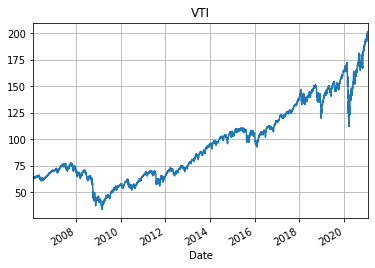

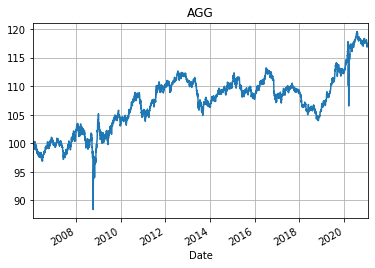

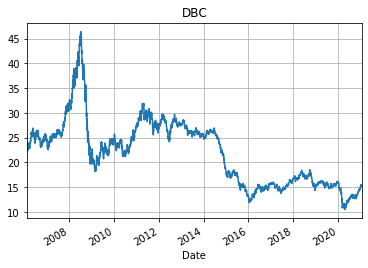

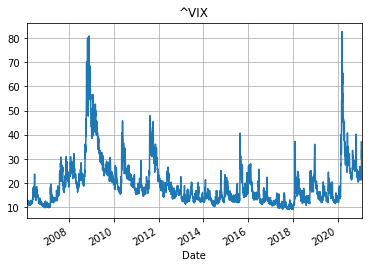

In [5]:
# let's plot them to check
for j in panel_data.keys():
    panel_data[j].plot();
    plt.grid()
    plt.title(j)
    plt.show()

In [6]:
# Compute returns and average returns among them (equally weighted portfolio)
panel_data_r = panel_data.pct_change().dropna()
panel_data_r['equally weighted'] = panel_data_r.mean(axis=1)

In [7]:
# Estimate model with full sample
model = Model.Model()
model.train_model(panel_data)

Epoch 1/100
53/53 [==============================] - 0s 8ms/step - loss: -0.5080 - val_loss: -0.3868
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: -0.7836 - val_loss: -0.6983
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: -0.9563 - val_loss: -0.6975
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: -1.0892 - val_loss: -0.7427
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: -1.1881 - val_loss: -0.7432
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: -1.1177 - val_loss: -0.5287
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: -1.2834 - val_loss: -0.5341
Epoch 8/100
53/53 [==============================] - 0s 2ms/step - loss: -1.1025 - val_loss: -0.6897
Epoch 9/100
53/53 [==============================] - 0s 2ms/step - loss: -1.5331 - val_loss: -0.8712
Epoch 10/100
53/53 [==============================] - 0s 2ms/step - loss: -1.5065 - val_los

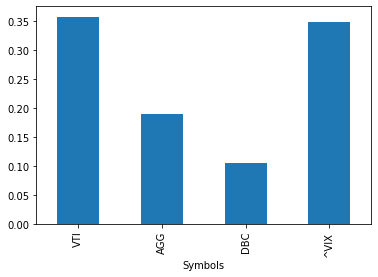

In [8]:
# plot insample weights
last_allocation = pd.DataFrame(model.predict_allocation(panel_data)[-1])
last_allocation.index = panel_data.columns
last_allocation.plot.bar()
plt.legend().remove()

In [9]:
# run out of sample
start_oos = '2011-01-01'
oos_dates = panel_data.index[panel_data.index>start_oos]
re_est_every = 1 # re-estimation every Jan
keep_count=0
wei_t = np.zeros((len(oos_dates), len(panel_data.columns)))
port_r_t = np.zeros(len(oos_dates))
for j, t in enumerate(tqdm(list(oos_dates))):
    data_now = panel_data[panel_data.index<=t]
    if t.month==re_est_every and keep_count==0:
        model = Model.Model()
        model.train_model(data_now[:-1], verbose=0)
        keep_count += 1
    elif t.month!=re_est_every:
        keep_count = 0
    wei_t[j] = model.predict_allocation(data_now[:-1])[-1]                        # get weights
    port_r_t[j] = wei_t[j] @ data_now.pct_change().values[-1]                     # compute port. returns

100%|██████████████████████████████████████████████████████████████████████████████| 2536/2536 [08:08<00:00,  5.19it/s]


In [10]:
# collect all results in dataframes
pd_weights = pd.DataFrame(wei_t)
pd_weights.index = oos_dates
pd_weights.columns = panel_data.columns
panel_data_r = panel_data_r[panel_data_r.index>start_oos]
panel_data_r['DPO_LSTM'] = port_r_t
panel_data_r_gros = panel_data_r+1

Text(0.5, 1.0, 'weights DPO LSTM')

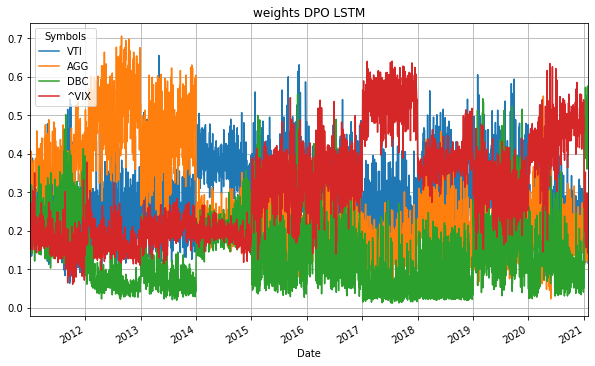

In [11]:
# plot weights
pd_weights.plot(figsize=(10,6))
plt.grid()
plt.title('weights DPO LSTM')

In [12]:
# print sharpe ratios
print('Daily Sharpe Ratios')
print((panel_data_r.mean() / panel_data_r.std()))

Daily Sharpe Ratios
Symbols
VTI                 0.044531
AGG                 0.017220
DBC                -0.018261
^VIX                0.041547
equally weighted    0.051928
DPO_LSTM            0.050346
dtype: float64


In [13]:
# print end of period NAV
print('end of period NAV')
print(panel_data_r_gros.cumprod()[-1:])

end of period NAV
Symbols          VTI       AGG       DBC      ^VIX  equally weighted  \
Date                                                                   
2021-01-29  2.987679  1.109314  0.551361  1.864225          7.633376   

Symbols      DPO_LSTM  
Date                   
2021-01-29  13.184957  


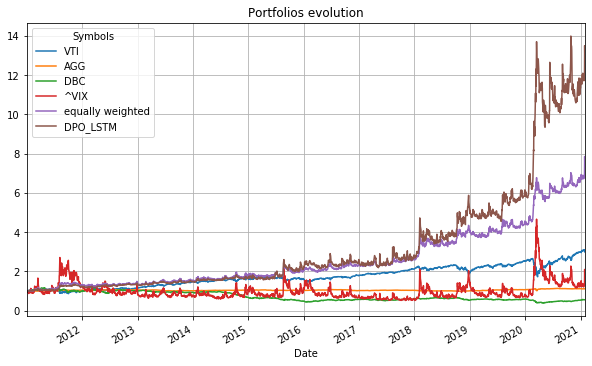

In [14]:
# plot portfolio evolution
panel_data_r_gros.cumprod().plot(figsize=(10,6));
plt.grid();
plt.title('Portfolios evolution');